In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import random
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
# from torchinfo import summary
from tqdm.notebook import tqdm
import yaml

from unet import *

from deepinvhessian import fwi_born, prepare_data, train

import warnings
warnings.filterwarnings('ignore')

In [3]:
# https://github.com/swag-kaust/Transform2022_SelfSupervisedDenoising/blob/main/tutorial_utils.py
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    
    Parameters
    ----------
    seed: int 
        Integer to be used for the seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    return True

set_seed(14)

True

In [4]:
# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
# Define the model and acquisition parameters

par = {

        # model parameters
        'nx':500,   'dx':5.,        'ox':0,
        'nz':251,   'dz':5.,        'oz':0,
        'nr':250,   'dr':10,       'orec':0,  'rz':0,
        'ns':25,    'ds':100,       'osou':50,  'sz':0,
        'nt':500,   'dt':0.004,     'ot':0,

        # Inversion parameters
        'FWI_itr': 100, 'num_dims':2,
        'batch_size':1,
        'fwi_pass': 1,   # This is a count in case the code stopped and you want to resume 
        'freq' : 5,       # Dominant frequency


       # Input files 
        'vel_true': '../data/SEAM_Vp_Elastic_N23900_chop.bin',
   
         

#         # others parameters 
        'vel_true_path':'',


    }



num_sources_per_shot=1    
fs = 1/par['dt'] # sampling frequency

 
par ['num_batches'] = par['ns']//par ['batch_size'] 


# declare all the par in local variables
for k in par:
    locals()[k] = par[k]


exp_name = 'Exp-FWI-Born'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

# Save the parametrs of this experiment (P.S. I save the parameter in the vel_path which is the main output)
with open(f'{exp_name}/parameters.yml', 'w') as outfile:
    yaml.dump(par, outfile, default_flow_style=False)

In [6]:
# ----------------------- input files ---------------------------------

Fvel =  par['vel_true_path'] +   par['vel_true']
    
# Load the true model
model_true = (np.fromfile(Fvel, np.float32).reshape(nx, nz))
model_true = np.transpose(model_true)

Text(0.5, 1.0, 'True Model')

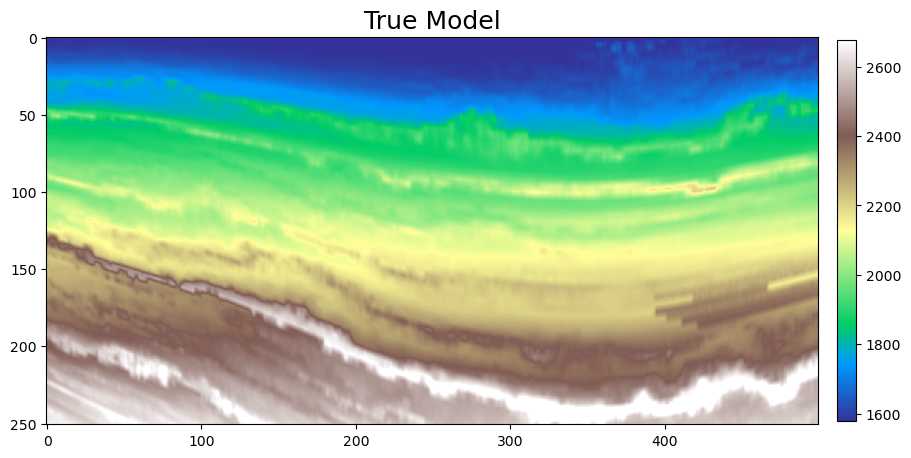

In [7]:
plt.figure(figsize=(12,8))
dm_vmin, dm_vmax = np.percentile(model_true, [2,98])
plt.imshow(model_true, vmin=dm_vmin, vmax=dm_vmax, cmap='terrain')
plt.colorbar(shrink=0.62, pad=0.02)
plt.title('True Model', fontsize=18)

In [8]:
model_true = torch.tensor(model_true, dtype=torch.float32)
# initiate the fwi class
params = fwi_born.FWIParams(par, acquisition=1)
# Create the source wavelet
wavel = fwi_born.Ricker(params).repeat(1,ns,1)
# Compute the true data
data_true = fwi_born.forward_modelling(params, model_true, wavel, device).cpu()

Text(0, 0.5, 'Time (ms)')

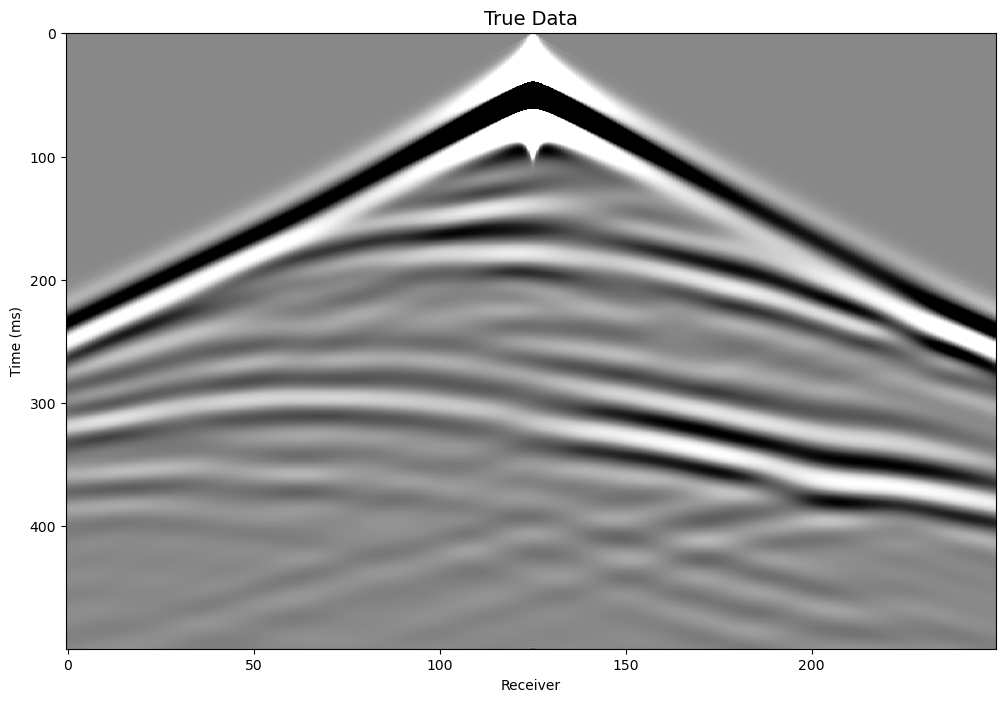

In [9]:
data_true = data_true.detach()
plt.figure(figsize=(12,8))
vmin, vmax = np.percentile(data_true[:, 12], [2,98])
plt.imshow(data_true[:, 12], aspect='auto', vmin=vmin, vmax=vmax, cmap= 'Greys')
plt.title('True Data', fontsize=14)
plt.xlabel('Receiver')
plt.ylabel('Time (ms)')

In [9]:
# Create initial guess model for inversion by smoothing the true model
model_init = gaussian_filter(model_true.cpu().detach(), sigma=15)
model_init = torch.tensor(model_init)
# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone().to(device)
model.requires_grad = True

scatter = torch.zeros_like(model)
scatter.requuires_grad = True

msk = torch.ones_like(model)
msk[:20] = 0
msk = msk.to(device)

depth = torch.tensor(list(range(0, 251))*500).reshape(500, 251).T /251
depth = depth.to(device)

In [10]:
optimizer_fwi = torch.optim.SGD([{'params': [model], 'lr': 1e2,}])
optimizer_dm1 = torch.optim.SGD([{'params': [scatter], 'lr': 1,}])
network = UNet(n_channels=2, n_classes=1, hidden_channels=64).to(device)
optimizer_unet = torch.optim.Adam(network.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

In [11]:
gradients, dm1s, gradients_network, dms, updates = [], [], [], [], []
data_loss, vel_loss, network_loss = [], [], []
for itr in tqdm(range(FWI_itr)):
    # compute the velocity difference
    vel_loss.append(loss_fn(model, model_true.to(device)).item())
    print(f'Iteration {itr}: velocity loss = {vel_loss[-1]}')
    # compute the FWI gradient and the data misfit
    grad, loss = fwi_born.compute_gradient(params, model, data_true, wavel, optimizer_fwi, device)
    print(f'Iteration {itr}: data loss = {loss}')
    data_loss.append(loss)
    # Normalize by the maximum of the first gradient and mask the shallow part
    if itr == 0: gmax = (torch.abs(grad.detach())).max()
    grad = (grad / gmax) * msk
    gradients.append(grad.detach().cpu().numpy())
    
    # compute the remigrated image from the gradient
    scatter.data[:] = grad.data[:].detach().clone()
    scatter.requires_grad = True
    dm1 = fwi_born.compute_dm1(params, model, scatter, wavel, optimizer_dm1, device)
    # Normalize by the maximum and mask the shallow part
    if itr == 0: dm1max = 1e1* (torch.abs(dm1.detach())).max()
    dm1 = (dm1 / dm1max) * msk
    dm1s.append(dm1.detach().cpu().numpy())
    # create training data for the network to learn the inverse of the Hessian
    train_dataloader = prepare_data(dm1.detach(), depth, grad.detach(), patch_size=32, slide=8, batch_size=64)
    # train the network
    network_iter = 30 if itr == 0 else 5
    loss = train(network, train_dataloader, optimizer_unet, loss_fn, network_iter, device)
    network_loss.extend(loss)
    # Obtain the fitted gradient by the network
    with torch.no_grad():
        inp = torch.cat([dm1.detach().unsqueeze(0), depth.unsqueeze(0)])
        g = network(inp.unsqueeze(0)).squeeze() * msk
    gradients_network.append(g.detach().cpu().numpy())
    
    # Apply the network to the FWI gradient to get the Hessian corrected update 
    with torch.no_grad():
        inp = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)])
        dm = network(inp.unsqueeze(0)).squeeze() * msk
    dms.append(dm.detach().cpu().numpy())
    
    # Update the model
    model.grad.data[:] = dm.data[:].detach().clone()
    optimizer_fwi.step()
    updates.append(model.detach().cpu().numpy())
    del train_dataloader
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: velocity loss = 2141.5458984375
Iteration 0: data loss = 1.1411731833277372e-05


  0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.015574144772721874
Training Epoch 1, Loss = 0.00024790977134698015
Training Epoch 2, Loss = 0.00019185654559359866
Training Epoch 3, Loss = 0.000154689500549484
Training Epoch 4, Loss = 0.00015512015128407773
Training Epoch 5, Loss = 0.00013430684902785144
Training Epoch 6, Loss = 0.00012960791519064658
Training Epoch 7, Loss = 0.00012960365640145598
Training Epoch 8, Loss = 0.00010754935119264559
Training Epoch 9, Loss = 0.00012582286688163602
Training Epoch 10, Loss = 0.00011037660499591856
Training Epoch 11, Loss = 9.309126485901538e-05
Training Epoch 12, Loss = 9.426727881552378e-05
Training Epoch 13, Loss = 8.302734632332645e-05
Training Epoch 14, Loss = 9.012900691053729e-05
Training Epoch 15, Loss = 6.938148990408153e-05
Training Epoch 16, Loss = 8.581336467114834e-05
Training Epoch 17, Loss = 9.066173376649043e-05
Training Epoch 18, Loss = 6.785323489120678e-05
Training Epoch 19, Loss = 7.544040087012428e-05
Training Epoch 20, Loss = 6.731750367108878

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.330343450847602e-05
Training Epoch 1, Loss = 3.389173391898272e-05
Training Epoch 2, Loss = 4.342208768659975e-05
Training Epoch 3, Loss = 4.6796237435117686e-05
Training Epoch 4, Loss = 3.514736648617591e-05
Iteration 2: velocity loss = 1570.319091796875
Iteration 2: data loss = 5.94545751653186e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.5845186927671974e-05
Training Epoch 1, Loss = 2.3767855384671838e-05
Training Epoch 2, Loss = 2.3874001655320743e-05
Training Epoch 3, Loss = 2.5995034454407525e-05
Training Epoch 4, Loss = 1.9677603016616023e-05
Iteration 3: velocity loss = 1396.6241455078125
Iteration 3: data loss = 4.538141695320519e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.5917014530326316e-05
Training Epoch 1, Loss = 1.647735583295192e-05
Training Epoch 2, Loss = 1.5860815045587015e-05
Training Epoch 3, Loss = 1.6051852249873656e-05
Training Epoch 4, Loss = 2.1322288429313203e-05
Iteration 4: velocity loss = 1263.8568115234375
Iteration 4: data loss = 3.526760288252717e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3784770642672026e-05
Training Epoch 1, Loss = 1.0998941353832111e-05
Training Epoch 2, Loss = 1.4169213714280084e-05
Training Epoch 3, Loss = 1.5547649069298595e-05
Training Epoch 4, Loss = 1.1486394036111568e-05
Iteration 5: velocity loss = 1165.293212890625
Iteration 5: data loss = 2.8712246589179813e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1016988122826339e-05
Training Epoch 1, Loss = 9.464478968284847e-06
Training Epoch 2, Loss = 1.0033571483932866e-05
Training Epoch 3, Loss = 9.342643316617172e-06
Training Epoch 4, Loss = 7.232531235037159e-06
Iteration 6: velocity loss = 1086.995361328125
Iteration 6: data loss = 2.4042713562266727e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.054356282859682e-06
Training Epoch 1, Loss = 7.419114131063871e-06
Training Epoch 2, Loss = 6.239384248931624e-06
Training Epoch 3, Loss = 6.276034350865338e-06
Training Epoch 4, Loss = 6.946035105280387e-06
Iteration 7: velocity loss = 1022.3024291992188
Iteration 7: data loss = 2.0794316597516627e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0535768105197063e-05
Training Epoch 1, Loss = 5.356804199347571e-06
Training Epoch 2, Loss = 8.135893015641355e-06
Training Epoch 3, Loss = 4.461215606919295e-06
Training Epoch 4, Loss = 6.28148538061057e-06
Iteration 8: velocity loss = 977.4505004882812
Iteration 8: data loss = 1.8769604146484653e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.637337131534164e-06
Training Epoch 1, Loss = 3.542901397930323e-06
Training Epoch 2, Loss = 5.992301103284333e-06
Training Epoch 3, Loss = 5.494768065456774e-06
Training Epoch 4, Loss = 5.0141853450316145e-06
Iteration 9: velocity loss = 943.174072265625
Iteration 9: data loss = 1.7408865176093968e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.638821765718817e-06
Training Epoch 1, Loss = 4.752046540007166e-06
Training Epoch 2, Loss = 4.870556954212553e-06
Training Epoch 3, Loss = 4.190406872005363e-06
Training Epoch 4, Loss = 7.125209023405321e-06
Iteration 10: velocity loss = 917.4193725585938
Iteration 10: data loss = 1.6496272934318768e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.481745640853606e-06
Training Epoch 1, Loss = 4.340292179552075e-06
Training Epoch 2, Loss = 3.107451564074818e-06
Training Epoch 3, Loss = 4.095220724727423e-06
Training Epoch 4, Loss = 4.066588723626232e-06
Iteration 11: velocity loss = 895.7008666992188
Iteration 11: data loss = 1.580748923757369e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.6645005642568837e-06
Training Epoch 1, Loss = 3.7571668773286067e-06
Training Epoch 2, Loss = 4.114028454340787e-06
Training Epoch 3, Loss = 2.6592001319716243e-06
Training Epoch 4, Loss = 3.6222601138166178e-06
Iteration 12: velocity loss = 878.1983032226562
Iteration 12: data loss = 1.5322737105805118e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.8642422026838605e-06
Training Epoch 1, Loss = 4.328850389570375e-06
Training Epoch 2, Loss = 2.6075590523412437e-06
Training Epoch 3, Loss = 3.149846513812971e-06
Training Epoch 4, Loss = 3.4602200136813575e-06
Iteration 13: velocity loss = 863.9029541015625
Iteration 13: data loss = 1.4938438077649607e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.835179934206298e-06
Training Epoch 1, Loss = 5.125651458617058e-06
Training Epoch 2, Loss = 1.4655790178663915e-05
Training Epoch 3, Loss = 4.222209200549389e-06
Training Epoch 4, Loss = 1.201082737372203e-06
Iteration 14: velocity loss = 852.694580078125
Iteration 14: data loss = 1.4662123462017007e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4301928561008918e-06
Training Epoch 1, Loss = 1.1935211075836503e-06
Training Epoch 2, Loss = 1.2898001208597242e-06
Training Epoch 3, Loss = 1.939107798253805e-06
Training Epoch 4, Loss = 1.7561343868772598e-06
Iteration 15: velocity loss = 841.8557739257812
Iteration 15: data loss = 1.440342883185508e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7184155874296194e-06
Training Epoch 1, Loss = 1.7865148547615735e-06
Training Epoch 2, Loss = 1.4692839888717644e-06
Training Epoch 3, Loss = 6.200088061886538e-06
Training Epoch 4, Loss = 3.86983377804391e-06
Iteration 16: velocity loss = 831.2216186523438
Iteration 16: data loss = 1.420966052378958e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.40256948596631e-06
Training Epoch 1, Loss = 1.4852370726408016e-06
Training Epoch 2, Loss = 1.2514516211637124e-06
Training Epoch 3, Loss = 1.2544047309552742e-06
Training Epoch 4, Loss = 1.5457699420244798e-06
Iteration 17: velocity loss = 824.361572265625
Iteration 17: data loss = 1.405719379121706e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2913919347038602e-06
Training Epoch 1, Loss = 1.7020228039329738e-06
Training Epoch 2, Loss = 1.7915311095369664e-06
Training Epoch 3, Loss = 1.2588492437566411e-06
Training Epoch 4, Loss = 2.0534547290623652e-06
Iteration 18: velocity loss = 818.0375366210938
Iteration 18: data loss = 1.392960593094017e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6898204417621658e-06
Training Epoch 1, Loss = 2.354964665278649e-06
Training Epoch 2, Loss = 1.4170306557429392e-06
Training Epoch 3, Loss = 1.2437765954419934e-06
Training Epoch 4, Loss = 7.237745748790414e-07
Iteration 19: velocity loss = 813.1685791015625
Iteration 19: data loss = 1.3825414839629957e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6458427304943303e-06
Training Epoch 1, Loss = 1.280997377715293e-06
Training Epoch 2, Loss = 1.2744084814892845e-06
Training Epoch 3, Loss = 1.0558594196958903e-06
Training Epoch 4, Loss = 1.239335744582836e-06
Iteration 20: velocity loss = 807.70263671875
Iteration 20: data loss = 1.3727088603587845e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3812230437737276e-06
Training Epoch 1, Loss = 1.9559429241397478e-06
Training Epoch 2, Loss = 1.3121554816814965e-06
Training Epoch 3, Loss = 1.5606406200990308e-06
Training Epoch 4, Loss = 9.454296161112217e-07
Iteration 21: velocity loss = 803.0877075195312
Iteration 21: data loss = 1.364497636657802e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.285815144922815e-07
Training Epoch 1, Loss = 9.499869236708714e-07
Training Epoch 2, Loss = 7.489742145873035e-07
Training Epoch 3, Loss = 9.5845673128866e-07
Training Epoch 4, Loss = 1.7172941392229904e-06
Iteration 22: velocity loss = 799.2182006835938
Iteration 22: data loss = 1.357699899173781e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.0138546816207393e-06
Training Epoch 1, Loss = 6.289595209445193e-07
Training Epoch 2, Loss = 1.2436199659091204e-06
Training Epoch 3, Loss = 1.4503577390582103e-06
Training Epoch 4, Loss = 1.1378131571915469e-06
Iteration 23: velocity loss = 796.398193359375
Iteration 23: data loss = 1.3519046273557933e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.872974987622321e-07
Training Epoch 1, Loss = 9.045111562054266e-07
Training Epoch 2, Loss = 1.3524885860324145e-06
Training Epoch 3, Loss = 1.453596845505324e-06
Training Epoch 4, Loss = 8.536469182422925e-07
Iteration 24: velocity loss = 793.1215209960938
Iteration 24: data loss = 1.3468408184280634e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5664880752901096e-06
Training Epoch 1, Loss = 1.4597511481588744e-06
Training Epoch 2, Loss = 6.07377253189435e-07
Training Epoch 3, Loss = 9.518272435673448e-07
Training Epoch 4, Loss = 1.214537760054278e-06
Iteration 25: velocity loss = 790.9131469726562
Iteration 25: data loss = 1.3428139240545534e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0284248388665684e-06
Training Epoch 1, Loss = 1.0617844299299667e-06
Training Epoch 2, Loss = 1.2824277588969845e-06
Training Epoch 3, Loss = 9.42235061947539e-07
Training Epoch 4, Loss = 8.827157778754037e-07
Iteration 26: velocity loss = 787.7334594726562
Iteration 26: data loss = 1.338301641951034e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6626668064654773e-06
Training Epoch 1, Loss = 5.751818395863523e-07
Training Epoch 2, Loss = 1.2251706247170927e-06
Training Epoch 3, Loss = 1.189576388870752e-06
Training Epoch 4, Loss = 8.167894084660438e-07
Iteration 27: velocity loss = 785.8440551757812
Iteration 27: data loss = 1.335082837172763e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.733495552543864e-07
Training Epoch 1, Loss = 8.88564278957525e-07
Training Epoch 2, Loss = 9.195680140313319e-07
Training Epoch 3, Loss = 1.3736536559730774e-06
Training Epoch 4, Loss = 8.023425810133698e-05
Iteration 28: velocity loss = 790.1431274414062
Iteration 28: data loss = 1.3498132584999212e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.399468605984308e-05
Training Epoch 1, Loss = 3.3574054338946463e-06
Training Epoch 2, Loss = 2.7549966794853675e-06
Training Epoch 3, Loss = 1.867120735877346e-06
Training Epoch 4, Loss = 1.4182232159024959e-06
Iteration 29: velocity loss = 789.38330078125
Iteration 29: data loss = 1.3404572598574305e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3681636639652352e-06
Training Epoch 1, Loss = 1.3273816066697798e-06
Training Epoch 2, Loss = 1.4219354689956555e-06
Training Epoch 3, Loss = 1.4193729364652587e-06
Training Epoch 4, Loss = 1.280193856700862e-06
Iteration 30: velocity loss = 788.470947265625
Iteration 30: data loss = 1.3354870667114938e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.192706784369126e-06
Training Epoch 1, Loss = 1.2785500470111883e-06
Training Epoch 2, Loss = 1.2606070807872611e-06
Training Epoch 3, Loss = 1.3626524258936615e-06
Training Epoch 4, Loss = 1.4476526638529821e-06
Iteration 31: velocity loss = 787.5076293945312
Iteration 31: data loss = 1.3329157706465367e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6195005492127343e-06
Training Epoch 1, Loss = 1.1954025327953537e-06
Training Epoch 2, Loss = 1.3127330364523896e-06
Training Epoch 3, Loss = 1.4291921226962514e-06
Training Epoch 4, Loss = 1.2527927162418386e-06
Iteration 32: velocity loss = 786.2623291015625
Iteration 32: data loss = 1.3304210018105778e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.491305713081102e-06
Training Epoch 1, Loss = 1.6041155329365246e-06
Training Epoch 2, Loss = 1.6533193690618503e-06
Training Epoch 3, Loss = 1.6604136088544157e-06
Training Epoch 4, Loss = 1.5149843917759996e-06
Iteration 33: velocity loss = 784.1815185546875
Iteration 33: data loss = 1.3264510734245505e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.0208499341722427e-06
Training Epoch 1, Loss = 1.266877388598361e-06
Training Epoch 2, Loss = 1.6476206352023177e-06
Training Epoch 3, Loss = 1.2675358399136195e-06
Training Epoch 4, Loss = 1.4980940815188233e-06
Iteration 34: velocity loss = 781.2631225585938
Iteration 34: data loss = 1.3213598144545813e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6076670016329944e-06
Training Epoch 1, Loss = 1.664490097856983e-06
Training Epoch 2, Loss = 1.9254700216116167e-06
Training Epoch 3, Loss = 2.229583612670824e-06
Training Epoch 4, Loss = 1.5708680368164756e-06
Iteration 35: velocity loss = 778.5222778320312
Iteration 35: data loss = 1.3177197644154148e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.475745617141251e-06
Training Epoch 1, Loss = 1.5879723848371998e-06
Training Epoch 2, Loss = 1.9859849479800292e-06
Training Epoch 3, Loss = 1.6823460351347689e-06
Training Epoch 4, Loss = 1.0768174920976177e-06
Iteration 36: velocity loss = 775.8778686523438
Iteration 36: data loss = 1.3142372541352643e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7283948932122167e-06
Training Epoch 1, Loss = 2.195308180226479e-06
Training Epoch 2, Loss = 1.2466415979343212e-06
Training Epoch 3, Loss = 1.4593803177162687e-06
Training Epoch 4, Loss = 1.4632661806418208e-06
Iteration 37: velocity loss = 773.1697387695312
Iteration 37: data loss = 1.3110708394492576e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2084456280789192e-06
Training Epoch 1, Loss = 1.667565536915087e-06
Training Epoch 2, Loss = 1.1771899487618664e-06
Training Epoch 3, Loss = 1.9427799343827476e-06
Training Epoch 4, Loss = 1.5190392708054965e-06
Iteration 38: velocity loss = 770.953369140625
Iteration 38: data loss = 1.3084827052978198e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1971017461492545e-06
Training Epoch 1, Loss = 2.0105564879722626e-06
Training Epoch 2, Loss = 1.2243017261082559e-06
Training Epoch 3, Loss = 1.4527341233240484e-06
Training Epoch 4, Loss = 1.799056648491494e-06
Iteration 39: velocity loss = 768.4437866210938
Iteration 39: data loss = 1.3057225896062619e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.4222940244472364e-06
Training Epoch 1, Loss = 8.80630812681446e-07
Training Epoch 2, Loss = 1.0054994798262367e-06
Training Epoch 3, Loss = 1.3681236645888753e-06
Training Epoch 4, Loss = 1.2815253209991544e-06
Iteration 40: velocity loss = 766.3345336914062
Iteration 40: data loss = 1.3029173491219126e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5128719643839491e-06
Training Epoch 1, Loss = 1.7343718778362267e-06
Training Epoch 2, Loss = 1.2078304387850771e-06
Training Epoch 3, Loss = 1.4332979225619233e-06
Training Epoch 4, Loss = 1.8617179904367731e-06
Iteration 41: velocity loss = 763.8825073242188
Iteration 41: data loss = 1.2989774571536827e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.20124765310788e-07
Training Epoch 1, Loss = 9.723747303817565e-07
Training Epoch 2, Loss = 1.2474530767487487e-06
Training Epoch 3, Loss = 1.946672663380281e-06
Training Epoch 4, Loss = 1.0994281904918263e-06
Iteration 42: velocity loss = 761.77734375
Iteration 42: data loss = 1.2959573467696828e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.050861360387417e-06
Training Epoch 1, Loss = 1.3445983433248507e-06
Training Epoch 2, Loss = 1.5266983330004188e-06
Training Epoch 3, Loss = 2.016465213960057e-06
Training Epoch 4, Loss = 1.1517115801356625e-06
Iteration 43: velocity loss = 759.7098388671875
Iteration 43: data loss = 1.2929562984709264e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6675820376679207e-06
Training Epoch 1, Loss = 1.4250071003806285e-06
Training Epoch 2, Loss = 8.96567408236639e-07
Training Epoch 3, Loss = 9.118825737036162e-07
Training Epoch 4, Loss = 2.2907607202858914e-06
Iteration 44: velocity loss = 757.7095336914062
Iteration 44: data loss = 1.2904603803320924e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1140067287812474e-06
Training Epoch 1, Loss = 1.005093470134139e-06
Training Epoch 2, Loss = 1.4893222678817135e-06
Training Epoch 3, Loss = 1.1139397198643137e-06
Training Epoch 4, Loss = 1.7104345053163415e-06
Iteration 45: velocity loss = 755.5859375
Iteration 45: data loss = 1.2874829309339475e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.195216775747266e-06
Training Epoch 1, Loss = 1.4629786772177028e-06
Training Epoch 2, Loss = 7.418945765872801e-07
Training Epoch 3, Loss = 1.2712713592410342e-06
Training Epoch 4, Loss = 1.7698123866471088e-06
Iteration 46: velocity loss = 753.3114013671875
Iteration 46: data loss = 1.2846505850205858e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.803845368120772e-07
Training Epoch 1, Loss = 1.1527924374042734e-06
Training Epoch 2, Loss = 1.6526770453948284e-06
Training Epoch 3, Loss = 1.6476493848759834e-06
Training Epoch 4, Loss = 1.2223742281909888e-06
Iteration 47: velocity loss = 750.9303588867188
Iteration 47: data loss = 1.2820418540115952e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3158236543751947e-06
Training Epoch 1, Loss = 1.024984354158982e-06
Training Epoch 2, Loss = 1.2540307583812334e-06
Training Epoch 3, Loss = 9.627454538335144e-07
Training Epoch 4, Loss = 2.005727828739456e-06
Iteration 48: velocity loss = 750.0750122070312
Iteration 48: data loss = 1.2803615838663518e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2512866573825152e-06
Training Epoch 1, Loss = 8.129202515147864e-07
Training Epoch 2, Loss = 1.8272966222670505e-06
Training Epoch 3, Loss = 7.269865183919441e-07
Training Epoch 4, Loss = 1.5329333315745031e-06
Iteration 49: velocity loss = 748.7327880859375
Iteration 49: data loss = 1.278564550233341e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0837779261045595e-06
Training Epoch 1, Loss = 8.631529200841874e-07
Training Epoch 2, Loss = 1.064441058102317e-06
Training Epoch 3, Loss = 1.0864748356412105e-06
Training Epoch 4, Loss = 1.7753113356730847e-06
Iteration 50: velocity loss = 747.3795166015625
Iteration 50: data loss = 1.2764718437807687e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2475941172526433e-06
Training Epoch 1, Loss = 1.3419571707109021e-06
Training Epoch 2, Loss = 1.256613397877831e-06
Training Epoch 3, Loss = 1.2058805891438526e-06
Training Epoch 4, Loss = 1.19766846333224e-06
Iteration 51: velocity loss = 745.5370483398438
Iteration 51: data loss = 1.2743425195083091e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.768808004260863e-07
Training Epoch 1, Loss = 1.0525651117409235e-06
Training Epoch 2, Loss = 9.727436555945757e-07
Training Epoch 3, Loss = 1.5203608150912652e-06
Training Epoch 4, Loss = 1.1933511454826123e-06
Iteration 52: velocity loss = 744.1301879882812
Iteration 52: data loss = 1.2725568439009294e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1219309897672014e-06
Training Epoch 1, Loss = 1.0898114763391527e-06
Training Epoch 2, Loss = 1.069504533597419e-06
Training Epoch 3, Loss = 1.4965956650342502e-06
Training Epoch 4, Loss = 8.959371646320577e-07
Iteration 53: velocity loss = 742.8829345703125
Iteration 53: data loss = 1.2709995900195281e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0530697007389593e-06
Training Epoch 1, Loss = 9.490777452302769e-07
Training Epoch 2, Loss = 2.1255390566586677e-06
Training Epoch 3, Loss = 9.58886955859226e-07
Training Epoch 4, Loss = 9.245466337264873e-07
Iteration 54: velocity loss = 741.92333984375
Iteration 54: data loss = 1.2693597888358e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.484510817317962e-07
Training Epoch 1, Loss = 1.4125273487345969e-06
Training Epoch 2, Loss = 9.148409242354819e-07
Training Epoch 3, Loss = 1.983364197757528e-06
Training Epoch 4, Loss = 1.1967846663140995e-06
Iteration 55: velocity loss = 741.3641357421875
Iteration 55: data loss = 1.2681168399808485e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.441295171510515e-07
Training Epoch 1, Loss = 1.0209800872278755e-06
Training Epoch 2, Loss = 1.4693652874997247e-06
Training Epoch 3, Loss = 8.766740530556186e-07
Training Epoch 4, Loss = 1.4824516598514937e-06
Iteration 56: velocity loss = 740.307373046875
Iteration 56: data loss = 1.2671177884726603e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1413244752078504e-06
Training Epoch 1, Loss = 8.922010824433385e-07
Training Epoch 2, Loss = 1.2917871160033089e-06
Training Epoch 3, Loss = 8.98815678303489e-07
Training Epoch 4, Loss = 1.6146568225729105e-06
Iteration 57: velocity loss = 739.9649658203125
Iteration 57: data loss = 1.266162131585702e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.254437224492547e-06
Training Epoch 1, Loss = 1.1285536011067e-06
Training Epoch 2, Loss = 1.0496147814253573e-06
Training Epoch 3, Loss = 1.23760664190045e-06
Training Epoch 4, Loss = 1.6500968905686522e-06
Iteration 58: velocity loss = 738.90234375
Iteration 58: data loss = 1.264706433801166e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3534157119465817e-06
Training Epoch 1, Loss = 5.141091244920562e-07
Training Epoch 2, Loss = 8.117272809123082e-07
Training Epoch 3, Loss = 1.7287952692756745e-06
Training Epoch 4, Loss = 6.376842297779113e-07
Iteration 59: velocity loss = 737.889404296875
Iteration 59: data loss = 1.2633925656757583e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2016652591154632e-06
Training Epoch 1, Loss = 1.6854268631718964e-06
Training Epoch 2, Loss = 6.900231525162103e-07
Training Epoch 3, Loss = 5.703294103305583e-07
Training Epoch 4, Loss = 8.248118098933054e-07
Iteration 60: velocity loss = 736.6813354492188
Iteration 60: data loss = 1.2618223035332221e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6461091884785477e-06
Training Epoch 1, Loss = 1.1217946433036701e-06
Training Epoch 2, Loss = 1.0190183975761976e-06
Training Epoch 3, Loss = 7.080787614980039e-07
Training Epoch 4, Loss = 9.551029725016366e-07
Iteration 61: velocity loss = 736.6076049804688
Iteration 61: data loss = 1.2601813761392577e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.520003909896706e-07
Training Epoch 1, Loss = 7.208506810722307e-07
Training Epoch 2, Loss = 1.1580482236592848e-06
Training Epoch 3, Loss = 2.096667546508717e-06
Training Epoch 4, Loss = 1.400834247032007e-06
Iteration 62: velocity loss = 736.5208129882812
Iteration 62: data loss = 1.2597236729305905e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.087359233644034e-07
Training Epoch 1, Loss = 5.589106034805951e-07
Training Epoch 2, Loss = 1.2389747883157814e-06
Training Epoch 3, Loss = 7.294486802127758e-07
Training Epoch 4, Loss = 1.303209197201385e-06
Iteration 63: velocity loss = 736.2908935546875
Iteration 63: data loss = 1.258641237456004e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.921007244661179e-07
Training Epoch 1, Loss = 8.899422998270518e-07
Training Epoch 2, Loss = 1.2664364022311127e-06
Training Epoch 3, Loss = 8.229551418017032e-07
Training Epoch 4, Loss = 1.2106701575197464e-06
Iteration 64: velocity loss = 735.3992919921875
Iteration 64: data loss = 1.2571521121884643e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0369329294123827e-06
Training Epoch 1, Loss = 5.874713474552254e-07
Training Epoch 2, Loss = 2.2384582719353727e-06
Training Epoch 3, Loss = 1.1172564915582103e-06
Training Epoch 4, Loss = 3.826036003225258e-07
Iteration 65: velocity loss = 734.704833984375
Iteration 65: data loss = 1.2557421484871156e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.354396302912409e-07
Training Epoch 1, Loss = 1.5053052695402674e-06
Training Epoch 2, Loss = 1.118465150944294e-06
Training Epoch 3, Loss = 1.188765563198353e-06
Training Epoch 4, Loss = 1.1667657665995256e-06
Iteration 66: velocity loss = 733.2817993164062
Iteration 66: data loss = 1.2539143448009327e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.528275799892749e-07
Training Epoch 1, Loss = 5.249360018736155e-07
Training Epoch 2, Loss = 7.214562124184286e-07
Training Epoch 3, Loss = 9.848558554650998e-07
Training Epoch 4, Loss = 1.0765512130029832e-06
Iteration 67: velocity loss = 731.11767578125
Iteration 67: data loss = 1.2522207430976096e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0284429303991976e-06
Training Epoch 1, Loss = 7.406199731231116e-07
Training Epoch 2, Loss = 7.579226136983255e-07
Training Epoch 3, Loss = 1.011667351059598e-06
Training Epoch 4, Loss = 1.2421948208701032e-06
Iteration 68: velocity loss = 728.965087890625
Iteration 68: data loss = 1.2509025397733353e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6453207731847125e-06
Training Epoch 1, Loss = 9.392941155330364e-07
Training Epoch 2, Loss = 1.4433747581370416e-06
Training Epoch 3, Loss = 8.852956941821361e-07
Training Epoch 4, Loss = 8.189144144150269e-07
Iteration 69: velocity loss = 727.607666015625
Iteration 69: data loss = 1.249511563550243e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.5211617337965397e-07
Training Epoch 1, Loss = 9.568692839386183e-07
Training Epoch 2, Loss = 1.4623550886121135e-06
Training Epoch 3, Loss = 1.413914067483142e-06
Training Epoch 4, Loss = 1.1517817559833662e-06
Iteration 70: velocity loss = 725.9342651367188
Iteration 70: data loss = 1.2476828050722588e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.131821324039194e-07
Training Epoch 1, Loss = 5.136761510963576e-07
Training Epoch 2, Loss = 4.4212990232773676e-07
Training Epoch 3, Loss = 6.437022194052356e-07
Training Epoch 4, Loss = 9.671702623095638e-07
Iteration 71: velocity loss = 724.4054565429688
Iteration 71: data loss = 1.2458799067971427e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1101804507156173e-06
Training Epoch 1, Loss = 1.1450066960280452e-06
Training Epoch 2, Loss = 6.758821557156682e-07
Training Epoch 3, Loss = 1.3287172754305585e-06
Training Epoch 4, Loss = 5.559827278480221e-07
Iteration 72: velocity loss = 723.0543212890625
Iteration 72: data loss = 1.2442452463901077e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1329891124461813e-06
Training Epoch 1, Loss = 7.740044787405899e-07
Training Epoch 2, Loss = 7.506767564856162e-07
Training Epoch 3, Loss = 1.0518888018395955e-06
Training Epoch 4, Loss = 2.0643070767538815e-06
Iteration 73: velocity loss = 722.0902099609375
Iteration 73: data loss = 1.2430858280509938e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.5336714962599326e-07
Training Epoch 1, Loss = 3.7936533900330117e-07
Training Epoch 2, Loss = 7.690502512809425e-07
Training Epoch 3, Loss = 1.0094638329247555e-06
Training Epoch 4, Loss = 1.3255788718369081e-06
Iteration 74: velocity loss = 721.1928100585938
Iteration 74: data loss = 1.2419733739221783e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.604189470206068e-07
Training Epoch 1, Loss = 6.056754673921864e-07
Training Epoch 2, Loss = 4.1975488594338387e-07
Training Epoch 3, Loss = 8.618998423032156e-07
Training Epoch 4, Loss = 1.586530080330436e-06
Iteration 75: velocity loss = 720.2393798828125
Iteration 75: data loss = 1.2407478875431366e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.099640779064403e-07
Training Epoch 1, Loss = 6.879338275156192e-07
Training Epoch 2, Loss = 6.191499418086025e-07
Training Epoch 3, Loss = 1.2980215315143836e-06
Training Epoch 4, Loss = 9.446179781909504e-07
Iteration 76: velocity loss = 719.1236572265625
Iteration 76: data loss = 1.2395013442301206e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.49911946427974e-07
Training Epoch 1, Loss = 4.571027826402457e-07
Training Epoch 2, Loss = 1.3159324798467049e-06
Training Epoch 3, Loss = 1.0094192104229835e-06
Training Epoch 4, Loss = 1.1309715410464725e-06
Iteration 77: velocity loss = 718.31591796875
Iteration 77: data loss = 1.2383306771113212e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.229418547065774e-07
Training Epoch 1, Loss = 6.839183677252371e-07
Training Epoch 2, Loss = 4.7503874221618784e-07
Training Epoch 3, Loss = 1.4063498135627407e-06
Training Epoch 4, Loss = 1.2150325136083076e-06
Iteration 78: velocity loss = 717.3019409179688
Iteration 78: data loss = 1.237209299453923e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0496048803606397e-06
Training Epoch 1, Loss = 1.0025008865222934e-06
Training Epoch 2, Loss = 6.965646974776973e-07
Training Epoch 3, Loss = 5.354664814382093e-07
Training Epoch 4, Loss = 1.4173353569483827e-06
Iteration 79: velocity loss = 716.9202270507812
Iteration 79: data loss = 1.236450985153681e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.240561037220723e-07
Training Epoch 1, Loss = 6.672064812274879e-07
Training Epoch 2, Loss = 6.992493987755712e-07
Training Epoch 3, Loss = 8.190503593522515e-07
Training Epoch 4, Loss = 1.229608333305493e-06
Iteration 80: velocity loss = 716.4400634765625
Iteration 80: data loss = 1.2356413874314853e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.612777038857895e-07
Training Epoch 1, Loss = 1.2204909791832693e-06
Training Epoch 2, Loss = 1.0869328267590078e-06
Training Epoch 3, Loss = 4.1060473602458075e-07
Training Epoch 4, Loss = 5.597876168357797e-07
Iteration 81: velocity loss = 716.0098876953125
Iteration 81: data loss = 1.2349710045711504e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.943672842910277e-07
Training Epoch 1, Loss = 1.385728985990026e-06
Training Epoch 2, Loss = 4.901725884620896e-07
Training Epoch 3, Loss = 9.979329420682284e-07
Training Epoch 4, Loss = 9.427335232807505e-07
Iteration 82: velocity loss = 715.1187133789062
Iteration 82: data loss = 1.2338139603329523e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.054442291305323e-07
Training Epoch 1, Loss = 1.8706073566123923e-06
Training Epoch 2, Loss = 5.257898961883489e-07
Training Epoch 3, Loss = 5.727452302755196e-07
Training Epoch 4, Loss = 6.887158461136452e-07
Iteration 83: velocity loss = 714.566650390625
Iteration 83: data loss = 1.232860906696942e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.853799116081973e-07
Training Epoch 1, Loss = 7.696167589931431e-07
Training Epoch 2, Loss = 1.117169235517038e-06
Training Epoch 3, Loss = 5.493820375878546e-07
Training Epoch 4, Loss = 8.39498414348764e-07
Iteration 84: velocity loss = 714.2193603515625
Iteration 84: data loss = 1.2319121083237405e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7045799891416566e-06
Training Epoch 1, Loss = 6.648546012121303e-07
Training Epoch 2, Loss = 8.501534670320628e-07
Training Epoch 3, Loss = 4.808501873800625e-07
Training Epoch 4, Loss = 8.464729897583516e-07
Iteration 85: velocity loss = 714.3218994140625
Iteration 85: data loss = 1.2313683326325986e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.674610349268768e-07
Training Epoch 1, Loss = 7.028141028630376e-07
Training Epoch 2, Loss = 7.028810983353883e-07
Training Epoch 3, Loss = 1.0030317061110134e-06
Training Epoch 4, Loss = 1.588165181134645e-06
Iteration 86: velocity loss = 714.5283813476562
Iteration 86: data loss = 1.2308541270655837e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.423018729730507e-07
Training Epoch 1, Loss = 1.0433372763736325e-06
Training Epoch 2, Loss = 6.041709541026354e-07
Training Epoch 3, Loss = 4.751788567157113e-07
Training Epoch 4, Loss = 5.647574017679486e-07
Iteration 87: velocity loss = 713.8648071289062
Iteration 87: data loss = 1.2302410867803815e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.736594075463588e-07
Training Epoch 1, Loss = 9.799484304802023e-07
Training Epoch 2, Loss = 5.99010663049784e-07
Training Epoch 3, Loss = 5.820173364955895e-07
Training Epoch 4, Loss = 9.631995908142586e-07
Iteration 88: velocity loss = 713.5261840820312
Iteration 88: data loss = 1.2296038738313086e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6950093023452012e-06
Training Epoch 1, Loss = 5.471536007889301e-07
Training Epoch 2, Loss = 5.513526791724095e-07
Training Epoch 3, Loss = 1.1522263771250134e-06
Training Epoch 4, Loss = 6.652667370365091e-07
Iteration 89: velocity loss = 712.6854858398438
Iteration 89: data loss = 1.2286253792126445e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.492015272396648e-07
Training Epoch 1, Loss = 1.326539875871428e-06
Training Epoch 2, Loss = 7.900468391392892e-07
Training Epoch 3, Loss = 4.7394281168903144e-07
Training Epoch 4, Loss = 6.753354286772987e-07
Iteration 90: velocity loss = 711.8695678710938
Iteration 90: data loss = 1.227665364922359e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.49285747119491e-07
Training Epoch 1, Loss = 1.0653079866965884e-06
Training Epoch 2, Loss = 3.593528056037886e-07
Training Epoch 3, Loss = 1.233834286087104e-06
Training Epoch 4, Loss = 1.1540381333428313e-06
Iteration 91: velocity loss = 711.580322265625
Iteration 91: data loss = 1.2270786218238072e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.436910375296297e-07
Training Epoch 1, Loss = 1.0550627413473266e-06
Training Epoch 2, Loss = 1.5142604142096496e-06
Training Epoch 3, Loss = 5.21404748048317e-07
Training Epoch 4, Loss = 8.736482148960664e-07
Iteration 92: velocity loss = 711.3806762695312
Iteration 92: data loss = 1.2266844802155674e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.32850948696368e-07
Training Epoch 1, Loss = 8.568383426742074e-07
Training Epoch 2, Loss = 8.623947504351209e-07
Training Epoch 3, Loss = 6.021847992803273e-07
Training Epoch 4, Loss = 7.431112149503201e-07
Iteration 93: velocity loss = 711.79443359375
Iteration 93: data loss = 1.2263591555594644e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.248313866308308e-07
Training Epoch 1, Loss = 5.859749813740724e-07
Training Epoch 2, Loss = 8.271545436911105e-07
Training Epoch 3, Loss = 1.3044877769880928e-06
Training Epoch 4, Loss = 1.0364572487758903e-06
Iteration 94: velocity loss = 710.8820190429688
Iteration 94: data loss = 1.2256269430466205e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.139782165209284e-07
Training Epoch 1, Loss = 1.1029743111699717e-06
Training Epoch 2, Loss = 7.611272620968244e-07
Training Epoch 3, Loss = 4.316980447016454e-07
Training Epoch 4, Loss = 6.142333496381757e-07
Iteration 95: velocity loss = 710.25390625
Iteration 95: data loss = 1.225078190891793e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.851567715135602e-07
Training Epoch 1, Loss = 1.0286399350601481e-06
Training Epoch 2, Loss = 9.074569001069556e-07
Training Epoch 3, Loss = 5.822406151460601e-07
Training Epoch 4, Loss = 1.4371372157503022e-06
Iteration 96: velocity loss = 710.02197265625
Iteration 96: data loss = 1.2246726122100426e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.615219791138378e-07
Training Epoch 1, Loss = 1.43661714639453e-06
Training Epoch 2, Loss = 9.37998288435995e-07
Training Epoch 3, Loss = 3.4964184959061213e-07
Training Epoch 4, Loss = 3.8583686492411376e-07
Iteration 97: velocity loss = 709.7635498046875
Iteration 97: data loss = 1.2240924842643608e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1256415280838922e-06
Training Epoch 1, Loss = 9.82295909031617e-07
Training Epoch 2, Loss = 5.107481932637426e-07
Training Epoch 3, Loss = 3.164764338348549e-07
Training Epoch 4, Loss = 1.1674272180769941e-06
Iteration 98: velocity loss = 709.7462158203125
Iteration 98: data loss = 1.2236690558609098e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.63703127512435e-07
Training Epoch 1, Loss = 8.418786447406341e-07
Training Epoch 2, Loss = 1.1798695865371543e-06
Training Epoch 3, Loss = 6.746767446244638e-07
Training Epoch 4, Loss = 8.421441664106445e-07
Iteration 99: velocity loss = 710.6527099609375
Iteration 99: data loss = 1.2237051709718116e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.194903611842165e-07
Training Epoch 1, Loss = 6.383471687278344e-07
Training Epoch 2, Loss = 6.293261485965041e-07
Training Epoch 3, Loss = 8.516001257029146e-07
Training Epoch 4, Loss = 1.5577498736681316e-06


In [18]:
np.savez(f'{exp_name}/results', data_loss=np.array(data_loss), 
                            vel_loss=np.array(vel_loss), 
                            network_loss=np.array(network_loss),
        )
np.savez(f'{exp_name}/results2', gradients=np.array(gradients), 
                            dm1s=np.array(dm1s), 
                            gradients_network=np.array(gradients_network),
                            dms=np.array(dms),
                            updates=np.array(updates),)

In [13]:
def plot_results(gradients, dm1s, gradients_network, dms, iteration=0, save_path=None):
    r = 0.84
    fig, axs = plt.subplots(2, 2, figsize=(12,6))

    m_min, m_max = np.percentile(dms[iteration], [2,98])
    img1 = axs[0,0].imshow(gradients[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    plt.colorbar(img1, ax=axs[0,0], pad=0.02, shrink=r)
    axs[0,0].set_title(f'FWI Gradient', fontsize=14)
    axs[0,0].set_xlabel('(a)')

    img2 = axs[0,1].imshow(dm1s[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    plt.colorbar(img2, ax=axs[0,1], pad=0.02, shrink=r)
    axs[0,1].set_title(r'$\delta m_1$', fontsize=14)
    axs[0,1].set_xlabel('(b)')

    img3 = axs[1,0].imshow(gradients_network[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    fig.colorbar(img3, ax=axs[1,0], pad=0.02, shrink=r)
    axs[1,0].set_title(r'Network($\delta m_1$)', fontsize=14)
    axs[1,0].set_xlabel('(c)')


    img4 = axs[1,1].imshow(dms[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    axs[1,1].set_xlabel('(d)')
    fig.colorbar(img4, ax=axs[1,1], pad=0.02, shrink=r)
    axs[1,1].set_title(f'Network(gradient)', fontsize=14)
    fig.text(0.07, 0.5, 'Depth (m)', ha='center', va='center', rotation='vertical', fontsize=12)
    fig.text(0.5, 0.05, 'Inline (m)', ha='center', va='center', fontsize=12);

    plt.suptitle(f'Iteration {iteration+1}', x=0.5, y=0.92, fontsize=16);
    if save_path is not None:
        plt.savefig(f'{save_path}/results_{iteration}.png',  bbox_inches='tight', dpi=300)
    else:
        plt.show()

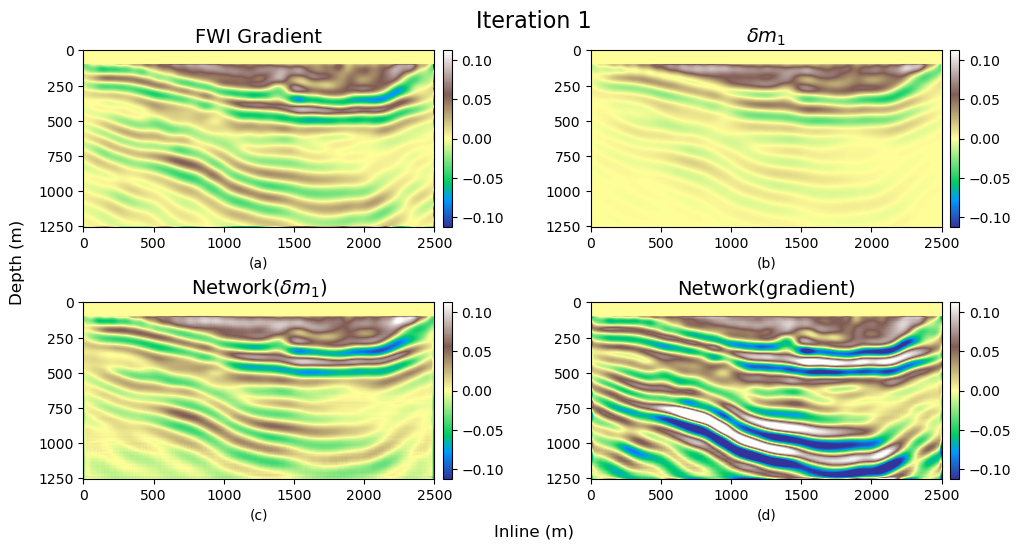

In [14]:
plot_results(gradients, dm1s, gradients_network, dms, iteration=0, save_path=None)

Text(0.5, 1.0, 'Updated Model')

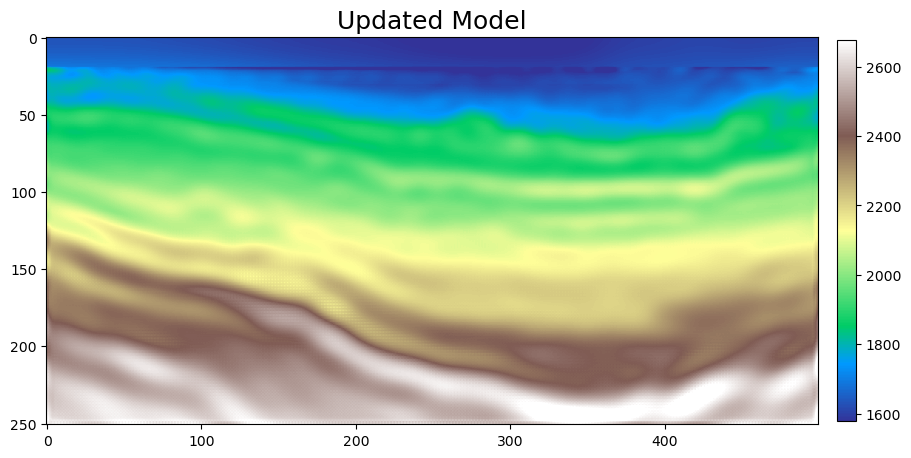

In [15]:
plt.figure(figsize=(12,8))
dm_vmin, dm_vmax = np.percentile(model_true, [2,98])
plt.imshow(updates[-1], vmin=dm_vmin, vmax=dm_vmax, cmap='terrain')
plt.colorbar(shrink=0.62, pad=0.02)
plt.title('Updated Model', fontsize=18)

Text(0.5, 0, 'WE solved')

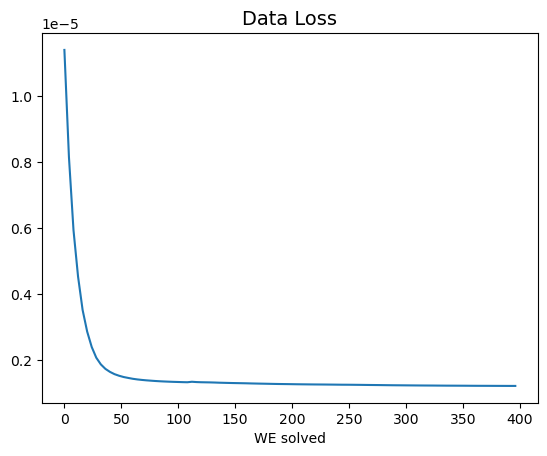

In [16]:
# Plot the data loss per number of wave equation solved 
plt.plot(np.arange(0, 400, 4), data_loss)
plt.title('Data Loss', fontsize=14)
plt.xlabel('WE solved')

Text(0.5, 0, 'WE solved')

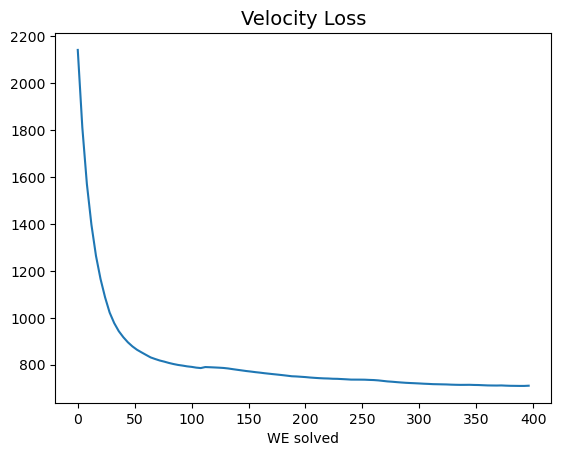

In [17]:
# Plot the velocity loss per number of wave equation solved 
plt.plot(np.arange(0, 400, 4), vel_loss)
plt.title('Velocity Loss', fontsize=14)
plt.xlabel('WE solved')